In [ ]:
### 只做单模型，其他的内容，等等再说，现在把单模型的表现提升上去再说吧
### 测试看下来，单纯得跑模型似乎会应该Y值的方差而产生巨大问题，我们需要重新做一次分类，明天的核心任务吧

In [38]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn import metrics
import datetime

import model_tunning as mt
import model_ml as mm
import feat_engineering as fe
import feat_selection as fs
from param_config import config
from sklearn import metrics

In [2]:
dfTrain = pd.read_csv(config.original_train_data_path)
dfPred = pd.read_csv(config.original_pred_data_path)
predictors = dfPred.columns.tolist()[4:]
check_missing = ['PartI_1','PartII_1','PartIII_1','PartIV_1','PartV_1','PartVI_1']


###清理异常Y值
dfTrain = dfTrain.loc[dfTrain['Y']<dfTrain['Y'].max()]
dfTrain = dfTrain.reset_index(drop=True)

#dfTrain = dfTrain.loc[dfTrain['Y']<=dfTrain['Y'].quantile(0.9)]

In [3]:
def FeatAll(train,pred,pcentByother=False,rankMinus=False,missing=False):
    dfAll = pd.concat([train,pred])
    dfAll = dfAll.reset_index(drop=True)
    dfAll['date'] = (pd.to_datetime(dfAll['date']) - parse('2017-10-09')).dt.days
    
    ###RF填补缺失值
    dfAll = fe.fillna_RF(dfAll,predictors,True)
       
    
    ###尝试处理异常值
    '''for var in predictors:
        dfAll.loc[dfAll[var]>=dfAll[var].quantile(0.99)*3,var] = dfAll[var].quantile(0.99)*3'''
        #dfAll.loc[dfAll[var]>=df[var].quantile(0.99)*1.5,var] = np.nan

    ###这个部分将每一列分箱，并且计算基于该列分类的其他列的百分比顺序
    if pcentByother:
        varDict = {}
        bin_set = 15
        for colBase in predictors+['sex','age']:
            if float(dfAll[colBase].isnull().sum())/dfAll.shape[0]>=0.4:
                print('Too many missing in variable %s'%colBase)
                continue
            if dfAll[colBase].nunique()<=5:
                varDict[colBase] = [x for x in predictors if x!=colBase]
            else:
                dfAll[colBase+'_based'] = pd.cut(dfAll[colBase],bins=bin_set,labels=[colBase+'_bin_%d'%i for i in range(bin_set)])
                dfAll[colBase+'_based'] = dfAll[colBase+'_based'].astype(str)
                dfAll[colBase+'_based'].fillna(colBase+'_bin_NA',inplace = True)
                varDict[colBase+'_based'] = [x for x in predictors if x!=colBase]
        try: 
            dfAllPcentByOther = pd.read_csv('../../Cache/pcent_by_other_bin%d.csv'%bin_set)
        except:
            print('There is no Pcent by other col, will generate and save')
            dfAllPcentByOther = fe.pcent_by_other_col(dfAll,varDict,['ID'])
            dfAllPcentByOther.to_csv('../../Cache/pcent_by_other_bin%d.csv'%bin_set,index=False)
        for var in dfAll.columns:
            if '_based' in var:
                del dfAll[var]
                
    if rankMinus:
        varList = []
        bin_set = 30
        for colBase in predictors:
            dfAll[colBase+'_based'] = pd.cut(dfAll[colBase],bins=bin_set,labels=range(bin_set))
            dfAll[colBase+'_based'] = dfAll[colBase+'_based'].astype(int)
            varList.append(colBase+'_based')
        try: 
            dfrankMinus = pd.read_csv('../../Cache/rankMinus_bin%d.csv'%bin_set)
        except:
            print('There is no Rank Minus, will generate and save')
            dfrankMinus = fe.var_minus(dfAll,varList,['ID'],0)
            dfrankMinus.to_csv('../../Cache/rankMinus_bin%d.csv'%bin_set,index=False)
            
    ###根据日期放置一个百分比顺序作为尝试
    dfAllPcentByDate = fe.pcent_by_other_col(dfAll,{'date':predictors},['ID']) 
    
    '''dfAll['date'] = pd.qcut(dfAll['date'],q=10,labels=['date_bin_%d'%i for i in range(10)])
    dfAll = pd.concat([dfAll,pd.get_dummies(dfAll['date'])],axis=1)'''
    ###目前不想使用日期，觉得用处不大
    del dfAll['date']

    #for minus in
    
    for plus in [['PartII_1','PartII_2'],['PartIII_1','PartIII_2','PartIII_3']]:
        tmpVar =plus[0]
        tmpValue = dfAll[plus[0]].values
        for var in plus[1:]:
            tmpVar = tmpVar +'_plus_' + var
            tmpValue = tmpValue + dfAll[var].values
        dfAll[tmpVar] = tmpValue
    
    dfAll['PartI_9'] = dfAll['PartI_5']-dfAll['PartI_6']-dfAll['PartI_7']
    dfAll['PartII_5'] = dfAll['PartII_2']-dfAll['PartII_3']-dfAll['PartII_4']
    
    for ratio in [['PartII_1','PartII_2'],['PartI_6','PartI_5'],['PartI_7','PartI_5'],['PartII_3','PartII_2'],['PartII_4','PartII_2'],['PartV_2','PartV_1'],['PartII_1','PartII_2']]:
        dfAll[ratio[0]+'_divided_'+ratio[1]] = dfAll[ratio[0]]/dfAll[ratio[1]]
        
    for multiply in [['PartI_1','PartI_5'],['PartI_2','PartI_5'],['PartI_3','PartI_5'],['PartI_4','PartI_5'],['PartVI_1','PartVI_2'],['PartV_2','PartV_5'],['PartV_2','PartV_7'],['PartV_1','PartV_9'],['PartV_1','PartV_10'],['PartV_1','PartV_11'],['PartV_1','PartV_12'],['PartV_1','PartV_13']]:
        dfAll[multiply[0]+'_multiply_'+multiply[1]] = dfAll[multiply[0]]*dfAll[multiply[1]]
    
    
    ###看看missing 的情况
    '''dfAll['missing_cnt'] = dfAll[check_missing].isnull().sum(axis=1)
    for i in range(len(check_missing)):
        dfAll['missing_part%d'%i] = dfAll[check_missing[i]].isnull().astype(int)'''
    
    
    '''for key,group in {'PartI':['PartI_1','PartI_2','PartI_3','PartI_4'],'PartII':['PartII_1','PartII_3','PartII_4']}.items():
        dfAll['group_'+key+'_std'] = dfAll[group].std(axis=1)
        dfAll['group_'+key+'_mean'] = dfAll[group].mean(axis=1)
        dfAll['group_'+key+'_median'] = dfAll[group].median(axis=1)'''
    
    
    try:
        dfAll = dfAll.merge(dfAllPcentByOther,'inner','ID')
    except:
        print('No Pcent by other col')
        
    try:
        dfAll = dfAll.merge(dfrankMinus,'inner','ID')
    except:
        print('No Rank Minus')
        
    
    dfAll = dfAll.merge(dfAllPcentByDate,'inner','ID')
    
    
    ###填补缺失值
    if missing:
        dfAll =dfAll.fillna(dfAll.median())
    
    dfTrain = dfAll.loc[dfAll['ID'].isin(train['ID'])]
    dfPred = dfAll.loc[dfAll['ID'].isin(pred['ID'])]
    
    return dfTrain,dfPred

In [4]:
dfTrain,dfPred = FeatAll(dfTrain,dfPred,True,True,True)
predictors = dfPred.columns.tolist()
predictors.remove('ID')
predictors.remove('Y')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
pd.set_option('display.max_rows',len(predictors))
len(predictors)


2027

In [15]:
dfTrainLow = dfTrain.loc[dfTrain['Y']<=dfTrain['Y'].quantile(0.9)]
dfTrainHigh = dfTrain.loc[dfTrain['Y']>dfTrain['Y'].quantile(0.9)]
dfTrainLow = dfTrainLow.reset_index(drop=True)
dfTrainHigh = dfTrainHigh.reset_index(drop=True)

In [ ]:
impDict = {}
for i in range(1000):
    predictorsRF = fs.RF_selection(dfTrainLow,predictors)
    for var in predictorsRF[0:501]:
        try:
            impDict[var] +=1
        except:
            impDict[var] = 1

In [7]:
predictorsLow = fs.RF_selection(dfTrainLow,predictors)
predictorsHigh = fs.RF_selection(dfTrainHigh,predictors)

In [12]:
dfAll = pd.concat([dfTrain,dfPred])
dfAll = dfAll.reset_index(drop=True)

In [13]:
n_splits=5
early_stop=50
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'reg:linear','lambda':1,'subsample':0.8,'colsample_bytree':0.8}

In [16]:
Lowtest_result,Lowresult,Lowimp = mm.xgb_kfold(dfTrainLow,dfAll,predictorsLow[0:201],n_splits,early_stop=early_stop,params=params)

No metric defined, will use rmse in the model
[0]	train-rmse:4.7325	eval-rmse:4.75656
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.79284	eval-rmse:1.81946
[200]	train-rmse:0.780691	eval-rmse:0.825444
[300]	train-rmse:0.489038	eval-rmse:0.559786
[400]	train-rmse:0.420387	eval-rmse:0.509712
[500]	train-rmse:0.399118	eval-rmse:0.501444
[600]	train-rmse:0.385861	eval-rmse:0.4996
Stopping. Best iteration:
[616]	train-rmse:0.383697	eval-rmse:0.499505

Best tree is 617, performance is 0.383697, 0.499505
No metric defined, will use rmse in the model
[0]	train-rmse:4.74424	eval-rmse:4.70921
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.79865	eval-rmse:1.77333
[200]	train-rmse:0.783967	eval-rmse:0.782194
[300]	train-rmse:0.491778	eval-rmse:0.527013
[400]	train-rmse:0

In [17]:
Hightest_result,Highresult,Highimp = mm.xgb_kfold(dfTrainHigh,dfAll,predictorsHigh[0:201],n_splits,early_stop=early_stop,params=params)

No metric defined, will use rmse in the model
[0]	train-rmse:8.85632	eval-rmse:8.71997
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:3.77876	eval-rmse:4.07036
[200]	train-rmse:1.99271	eval-rmse:2.9034
[300]	train-rmse:1.35833	eval-rmse:2.73805
Stopping. Best iteration:
[334]	train-rmse:1.25105	eval-rmse:2.72962

Best tree is 335, performance is 1.251052, 2.729619
No metric defined, will use rmse in the model
[0]	train-rmse:8.69445	eval-rmse:9.35638
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:3.72556	eval-rmse:4.61385
[200]	train-rmse:1.97992	eval-rmse:3.234
[300]	train-rmse:1.37302	eval-rmse:2.91967
[400]	train-rmse:1.08764	eval-rmse:2.84343
[500]	train-rmse:0.898207	eval-rmse:2.82958
Stopping. Best iteration:
[529]	train-rmse:0.849672	eval-rmse:2.82443

Best 

In [18]:
Lowresult['scoreLow']=Lowresult[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
Highresult['scoreHigh']=Highresult[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)

In [20]:
Highresult

,ID,Score_1,Score_2,Score_3,Score_4,Score_5,scoreHigh
0,1,7.895566,8.357316,8.030937,7.644376,7.696496,7.924938
1,2,7.703240,7.918730,7.398008,7.118474,7.739357,7.575562
2,3,7.214195,7.881251,7.357016,7.354088,7.551951,7.471700
3,4,8.029395,7.865658,8.509670,7.451525,8.073351,7.985920
4,5,8.307198,8.497120,8.671947,8.047948,8.600289,8.424900
5,6,7.466127,8.072802,7.983876,7.461512,8.055830,7.808029
6,7,7.962276,7.893395,8.190388,8.065804,8.141336,8.050639
7,8,8.366478,8.367626,8.830458,7.996313,8.245344,8.361244
8,9,7.894360,8.361977,8.504252,7.875354,7.898224,8.106833
9,10,9.717069,9.575384,8.843627,8.256012,8.471791,8.972776


In [23]:
test = pd.merge(Highresult.loc[Highresult['ID'].isin(dfTrain['ID']),['ID','scoreHigh']],Lowresult.loc[Lowresult['ID'].isin(dfTrain['ID']),['ID','scoreLow']],'inner','ID')
test = test.merge(dfTrain[['ID','Y']],'inner','ID')


In [24]:
test

,ID,scoreHigh,scoreLow,Y
0,1,7.924938,5.435819,6.06
1,2,7.575562,5.389307,5.39
2,3,7.471700,5.323558,5.59
3,4,7.985920,4.675590,4.30
4,5,8.424900,5.219712,5.42
5,6,7.808029,5.732423,5.97
6,7,8.050639,5.064405,5.11
7,8,8.361244,5.340884,5.94
8,9,8.106833,5.472713,5.66
9,10,8.972776,5.130093,5.48


In [25]:
###binary
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'binary:logistic','lambda':1,'subsample':0.8,'colsample_bytree':0.8,'eval_metric':'logloss'}
n_splits=5
early_stop=50
dfTrainBinary = dfTrain.copy()
dfTrainBinary['Y'] = 0
dfTrainBinary.loc[dfTrain['Y']>dfTrain['Y'].quantile(0.9),'Y'] =1
dfPredBinary = dfPred.copy()
test_result,result,imp = mm.xgb_kfold(dfTrainBinary,dfPredBinary,predictors,n_splits,early_stop = early_stop,params=params)



[0]	train-logloss:0.686001	eval-logloss:0.686563
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.327429	eval-logloss:0.371633
[200]	train-logloss:0.217571	eval-logloss:0.297354
[300]	train-logloss:0.169628	eval-logloss:0.277161
[400]	train-logloss:0.140797	eval-logloss:0.272079
[500]	train-logloss:0.120127	eval-logloss:0.270341
Stopping. Best iteration:
[503]	train-logloss:0.11944	eval-logloss:0.270251

Best tree is 504, performance is 0.119440, 0.270251
[0]	train-logloss:0.685985	eval-logloss:0.686475
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.327272	eval-logloss:0.368053
[200]	train-logloss:0.216962	eval-logloss:0.293896
[300]	train-logloss:0.169371	eval-logloss:0.273941
[400]	train-logloss:0.142408	eval-logloss:0.267856
[500]	train-logl

KS=0.502, AUC=0.83, N=5641
At threshold=0.099, TPR=0.41, 226 out of 557
At threshold=0.099, FPR=0.06, 329 out of 5084
Ave_target: [ 0.08865248  0.09574468  0.12234043  0.09042553  0.11347518  0.08865248
  0.08510638  0.10106383  0.11347518  0.08865248]
Ave_predicted: [ 0.09088159  0.07994051  0.09162989  0.0902589   0.08339633  0.08391938
  0.07992642  0.08514774  0.09501109  0.08424712]
plot


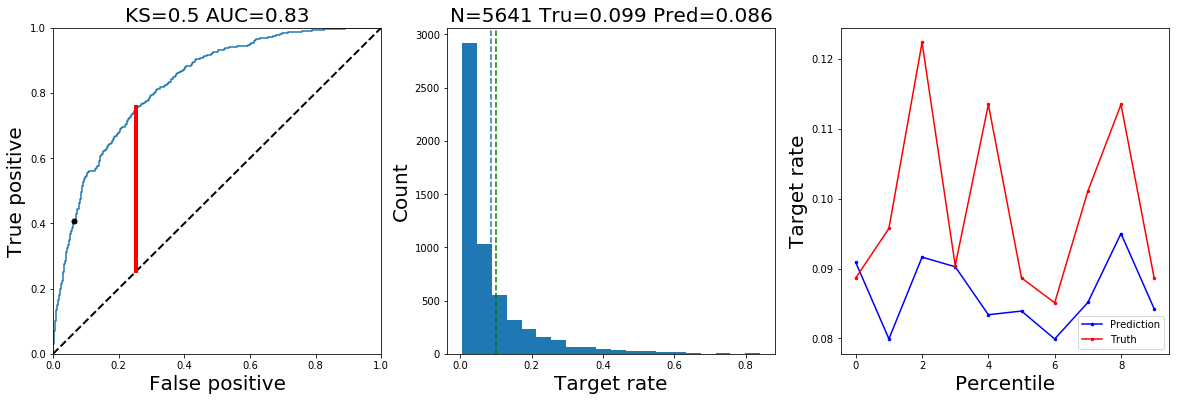

0.50190091913660206

In [29]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [30]:
for i in range(1,n_splits+1):
    imp['imp_fold%d'%i] = imp['imp_fold%d'%i]/imp['imp_fold%d'%i].sum()
imp['sum_imp'] = imp[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)
tmpPredictor = imp.sort_values('sum_imp',ascending=False)['variable'].values.tolist()[0:300]
test_result,result,imp_selected = mm.xgb_kfold(dfTrainBinary,dfPredBinary,tmpPredictor,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.685959	eval-logloss:0.686486
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.328173	eval-logloss:0.368935
[200]	train-logloss:0.219869	eval-logloss:0.293555
[300]	train-logloss:0.172616	eval-logloss:0.272711
[400]	train-logloss:0.145426	eval-logloss:0.266988
[500]	train-logloss:0.124931	eval-logloss:0.26643
Stopping. Best iteration:
[529]	train-logloss:0.119756	eval-logloss:0.26598

Best tree is 530, performance is 0.119756, 0.265980
[0]	train-logloss:0.686019	eval-logloss:0.68646
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.329035	eval-logloss:0.366881
[200]	train-logloss:0.220437	eval-logloss:0.29163
[300]	train-logloss:0.173052	eval-logloss:0.271019
[400]	train-logloss:0.145886	eval-logloss:0.26433
[500]	train-logloss:

KS=0.516, AUC=0.84, N=5641
At threshold=0.099, TPR=0.43, 237 out of 557
At threshold=0.099, FPR=0.06, 323 out of 5084
Ave_target: [ 0.09929078  0.10283688  0.08865248  0.10460993  0.10460993  0.09751773
  0.09574468  0.10638298  0.09929078  0.08865248]
Ave_predicted: [ 0.08996043  0.08391558  0.08987071  0.09197743  0.07762785  0.08577938
  0.07900436  0.09520637  0.09218455  0.08193661]
plot


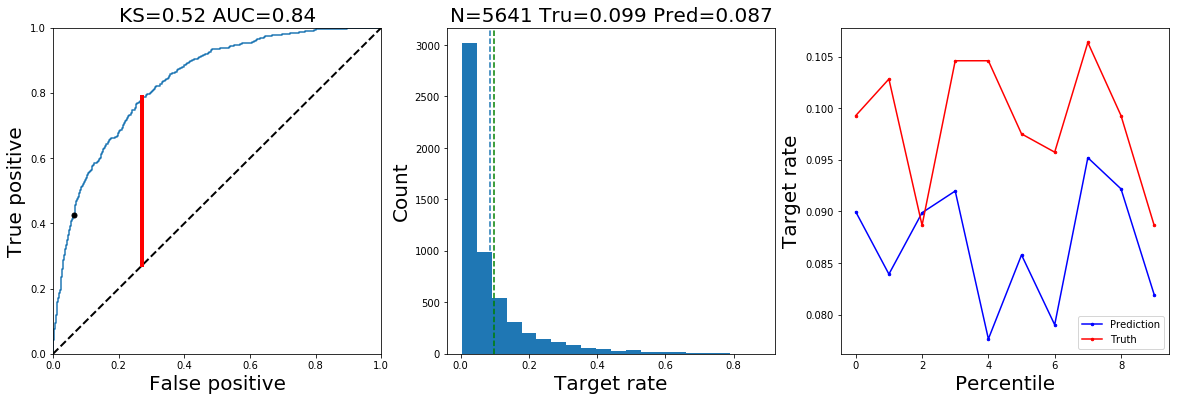

0.51550575113673758

In [31]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [33]:
#test = test.merge(test_result,'inner','ID')
test = test.rename(columns={'score':'scoreBinary'})

In [37]:
test['binaryRank'] = test.scoreBinary.rank()/len(test)

In [95]:
startPoint =0.55
test['ratio'] = test['binaryRank'].apply(lambda x:max([0,x-startPoint]))
test['score'] = test['scoreLow']*(1-test['ratio'])+test['ratio']*test['scoreHigh']
test.loc[test['binaryRank']>=0.9,'score'] = test.loc[test['binaryRank']>=0.9,'scoreHigh']

metrics.mean_squared_error(test['Y'], test['score'])

1.6645741455775382

In [72]:
ratio = 0.86
test['score'] = ratio*test['scoreLow']+(1-ratio)*test['scoreHigh']
metrics.mean_squared_error(test['Y'], test['score'])

1.8739318968418914

In [65]:
metrics.mean_squared_error(test['Y'], test['score'])

1.8962586743098573

In [41]:
test  1.7873535601519355   ///1.7398894976686199  ///1.7316692409803558 ///1.6645741455775382

,ID,scoreHigh,scoreLow,Y,scoreBinary,target,binaryRank,score
0,1,7.924938,5.435819,6.06,0.036713,0,0.458961,5.435819
1,2,7.575562,5.389307,5.39,0.043033,0,0.507711,5.389307
2,3,7.471700,5.323558,5.59,0.016565,0,0.223896,5.323558
3,4,7.985920,4.675590,4.30,0.010004,0,0.093955,4.675590
4,5,8.424900,5.219712,5.42,0.028399,0,0.380429,5.219712
5,6,7.808029,5.732423,5.97,0.138131,0,0.813508,5.732423
6,7,8.050639,5.064405,5.11,0.042178,0,0.501330,5.064405
7,8,8.361244,5.340884,5.94,0.156249,0,0.839567,5.340884
8,9,8.106833,5.472713,5.66,0.083537,0,0.690303,5.472713
9,10,8.972776,5.130093,5.48,0.042124,0,0.500798,5.130093


In [96]:
resultCombine = pd.merge(Highresult.loc[Highresult['ID'].isin(dfPred['ID']),['ID','scoreHigh']],Lowresult.loc[Lowresult['ID'].isin(dfPred['ID']),['ID','scoreLow']],'inner','ID')
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
resultCombine = resultCombine.merge(result,'inner','ID')
resultCombine = resultCombine.rename(columns={'score':'scoreBinary'})
resultCombine['binaryRank'] = resultCombine.scoreBinary.rank()/len(resultCombine)

resultCombine['ratio'] = resultCombine['binaryRank'].apply(lambda x:max([0,x-startPoint]))
resultCombine['score'] = resultCombine['scoreLow']*(1-resultCombine['ratio'])+resultCombine['ratio']*resultCombine['scoreHigh']

resultCombine.loc[resultCombine['binaryRank']>0.9,'score'] = resultCombine.loc[resultCombine['binaryRank']>0.9,'scoreHigh']

In [97]:
#result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
print((resultCombine['score']>6.8).sum())
print(resultCombine['score'].min())
print(resultCombine['score'].max())
print(resultCombine['score'].mean())
print(resultCombine['score'].median())
print("-------------------------")
print(resultCombine.iloc[938,:])

111
4.82489442825
13.0228700638
5.840472031654358
5.395951986312866
-------------------------
ID             6705.000000
scoreHigh        13.022870
scoreLow          5.671039
Score_1           0.752893
Score_2           0.864977
Score_3           0.796213
Score_4           0.710090
Score_5           0.772732
scoreBinary       0.779381
binaryRank        1.000000
ratio             0.450000
score            13.022870
Name: 938, dtype: float64


In [98]:
other_note ='_combineHL'
#result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
submit = resultCombine[['ID','score']]
today = datetime.date.today().strftime('%Y-%m-%d')
result.to_csv('../../Submission/result/result_%s'%today+other_note+'.csv',index=False)
submit['score'].to_csv('../../Submission/submit_%s'%today+other_note+'.csv',header=False,index=False)
test_result.to_csv('../../Submission/test/test_result_%s'%today+other_note+'.csv',index=False)
imp.to_csv('../../Submission/imp/importance_%s'%today+other_note+'.csv',index=False)

In [ ]:
n_splits=5
early_stop=50
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'reg:linear','lambda':1,'subsample':0.8,'colsample_bytree':0.8}
test_result,result,imp = mm.xgb_kfold(dfTrain,dfPred,predictorsHigh[:201],n_splits,early_stop=early_stop,params=params)

In [ ]:
for i in range(1,n_splits+1):
    imp['imp_fold%d'%i] = imp['imp_fold%d'%i]/imp['imp_fold%d'%i].sum()
imp['sum_imp'] = imp[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)

In [ ]:
tmpPredictor = imp.sort_values('sum_imp',ascending=False)['variable'].values.tolist()[0:100]
imp.sort_values('sum_imp',ascending=False).reset_index()

In [ ]:
test_result,result,imp_selected = mm.xgb_kfold(dfTrain,dfPred,tmpPredictor,n_splits,early_stop=early_stop,params=params)

In [ ]:
for i in range(1,n_splits+1):
    imp_selected['imp_fold%d'%i] = imp_selected['imp_fold%d'%i]/imp_selected['imp_fold%d'%i].sum()
imp_selected['sum_imp'] = imp_selected[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)
imp_selected.sort_values('sum_imp',ascending=False).reset_index()

In [ ]:
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
print((result['score']>6.8).sum())
print(result['score'].min())
print(result['score'].max())
print(result['score'].mean())
print(result['score'].median())
print("-------------------------")
print(result.iloc[938,:])

In [ ]:
dfTrain['Y'].mean()

In [ ]:
###基础变量
1.83977998784

###增加部分比例数据，已经缺失体检项目情况
1.84295123211  imp来看，missing信息没有意义

###上一版去除missing
1.83839589522



###增加一些比值信息
1.84354856365


###根据日期的百分比，效果更加不好了
1.85046680299  变量选择之后 1.83862284729



###前面所有的特征
1.86013896413   变量选择之后  1.85446185976
更改了一下模型的参数 1.81447588639  变量选择之后  1.80873726211
用中位数填补缺失值 1.81136029536  变量选择之后  1.80584671605
将异常值取空 然后按中位数填补 1.83149451674  变量选择之后  1.82105909448
将异常值cap 然后按中位数填补 1.80727635099  变量选择之后  1.81587223984
根据上一版用均值填补缺失（已有cap）  1.81374808226 ///   1.8175380386


###增加更多特征，主要涉及加减乘除
用中位数填补缺失值 1.81045571166 ///  1.78855151825  实际效果极差
不弥补缺失值  1.80566299608  ///  1.79592827524


####增加各列排行相减的变量，中位数填缺失，

In [ ]:
other_note ='_more_var_minus'
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
submit = result[['ID','score']]
today = datetime.date.today().strftime('%Y-%m-%d')
result.to_csv('../../Submission/result/result_%s'%today+other_note+'.csv',index=False)
submit['score'].to_csv('../../Submission/submit_%s'%today+other_note+'.csv',header=False,index=False)
test_result.to_csv('../../Submission/test/test_result_%s'%today+other_note+'.csv',index=False)
imp.to_csv('../../Submission/imp/importance_%s'%today+other_note+'.csv',index=False)